<a href="https://colab.research.google.com/github/mitesh98/Amazon-Fine-Food-Review/blob/master/DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Fine Food Reviews Analysis
Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454

Number of users: 256,059

Number of products: 74,258

Timespan: Oct 1999 - Oct 2012

Number of Attributes/Columns in data: 10

Attribute Information:

Id

ProductId - unique identifier for the product

UserId - unqiue identifier for the user

ProfileName

HelpfulnessNumerator - number of users who found the review helpful

HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not

Score - rating between 1 and 5

Time - timestamp for the review

Summary - brief summary of the review Text - text of the review

Objective: Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).



In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import re
import nltk

from sklearn import metrics
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

import tqdm

In [0]:
import sqlite3

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp "/content/drive/My Drive/database.sqlite" "database.sqlite"

# Reading Data

In [0]:
con=sqlite3.connect("database.sqlite")

In [6]:
filtered_data=pd.read_sql_query("SELECT * FROM `Reviews` WHERE `Score` !=3",con)
filtered_data.shape
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [0]:
# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

In [8]:
actual_score=filtered_data['Score']
posnegative=actual_score.map(partition)
filtered_data['Score']=posnegative
filtered_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# 2. Exploratory Data Analysis
# 2.1 Data Cleaning: Deduplication
It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId',axis=0,ascending=True)
sorted_data.shape

(525814, 10)

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'},keep='first',inplace=False)
final.shape

(364173, 10)

**Observation:-** bold text It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape

(364171, 10)

In [12]:
final['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

# 3. Preprocessing
In the Preprocessing phase we do the following in the order below:-

1.Begin by removing the linksand html tags

2.Expand English language contractions and Remove any punctuations or limited set of special characters like , or . or # etc.

3.Check if the word is made up of english letters and is not alpha-numeric

4.Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)

5.Convert the word to lowercase

6.Remove Stopwords

7.Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)



In [13]:
#print(link)
for i in range(0,1000):
  links=re.findall(r'http\S+',final['Text'].values[i])
  for link in links:
    print(link)

http://www.amazon.com/gp/product/B0002DGRSY">Pro-Treat
http://www.amazon.com/gp/product/B0019O5Z0Q">Charlee
http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br
http://www.amazon.com/gp/product/B0088EDMMS">Hocus
http://www.amazon.com/gp/product/B001AGXEAG">Beetlejuice
http://www.amazon.com/gp/product/B001AGXEAG">here</a>.
http://www.amazon.com/gp/product/B001AGXEA6">here</a>.
http://www.amazon.com/gp/product/0790700506">Gremlins</a><br
http://www.amazon.com/gp/product/6301871952">Gremlins
http://www.amazon.com/gp/product/6303347657">Mask</a><br
http://www.amazon.com/gp/product/6304826141">Rocketman</a><br
http://www.amazon.com/gp/product/B001B504LI">The
http://www.amazon.com/gp/product/B001AGXEA6">Beetlejuice
http://www.amazon.com/gp/product/B00004RAMX">Victor
http://www.amazon.com/gp/product/B00004RAMY">Victor
http://www.amazon.com/gp/product/B00004RAMY">Victor
http://www.amazon.com/gp/product/B001VJ3FP6">SentryHOME
http://www.amazon.com/gp/product/B0051GCTAW">Fiprogua

In [0]:
for i in range(0,364171):
  final['Text'].values[i] = re.sub(r"http\S+", "", final['Text'].values[i])

In [0]:
#Remove HTML tags
from bs4 import BeautifulSoup
for i in range(1,364171):
  soup = BeautifulSoup(final['Text'].values[i],'lxml')
  text = soup.get_text()
  final['Text'].values[i]=text

In [0]:
#Expanding English language contractions
def decontracted(phrase):
  # specific
  phrase = re.sub(r"won\'t", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)

  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase


In [0]:
for i in range(0,364171):
  #print(final['Text'].values[i])
  final['Text'].values[i]=decontracted(final['Text'].values[i])
  #print(final['Text'].values[i])

In [0]:
#remove words with numbers python
for i in range(1,364171):
  #print(final['Text'].values[i])
  final['Text'].values[i] = re.sub("\S*\d\S*", "", final['Text'].values[i]).strip()
  #print(final['Text'].values[i])

In [0]:
#remove spacial character:
for i in range(1,364171):
  final['Text'].values[i]= re.sub('[^A-Za-z0-9]+', ' ', final['Text'].values[i])


In [0]:
#Remove punctution
for i in range(1,364171):
  final['Text'].values[i]= re.sub(r'[!|#|$\%|&|*|?|,|.|\'|/|"|)|(]',r'', final['Text'].values[i])

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
#tqdm
#Instantly make your loops show a smart progress meter
# just wrap any iterable with tqdm(iterable), and you’re done!
from tqdm import tqdm
preprocessed_reviews = []
for i in tqdm(range(0,364171)):
  sentence=""
  #print(final['Text'].values[i])
  for word in final['Text'].values[i].split():
    #print(word)
    word =word.lower()
    if word not in stopwords:
      sentence+=" "+word
  #print(sentence)
  preprocessed_reviews.append(sentence.strip())

100%|██████████| 364171/364171 [00:15<00:00, 24217.10it/s]


In [24]:
final['Cleaned_text']=preprocessed_reviews
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud. recite...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version",I grew up reading these Sendak books and watch...,grew reading sendak books watching really rosi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud it h...,great little book read aloud nice rhythm well ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetry months year goes month cute little...


In [0]:
#Randomly sample Data 100k points
random_sample_data = final.sample(n=100000) 

In [0]:
final_sorted_time=random_sample_data.sort_values('Time',ascending=True,axis=0)

**Time Based Splitting**

In [0]:
y_Train=final_sorted_time['Score'][0:70000]
y_train=final_sorted_time['Score'][0:49000]
y_cv=final_sorted_time['Score'][49000:70000]
y_test=final_sorted_time['Score'][70000:100000]

In [28]:
y_train.value_counts()

1    42149
0     6851
Name: Score, dtype: int64

In [29]:
y_Train.value_counts()

1    59559
0    10441
Name: Score, dtype: int64

In [0]:
Train_data=final_sorted_time['Cleaned_text'][0:70000]
train_data=final_sorted_time['Cleaned_text'][0:49000]
cv_data=final_sorted_time['Cleaned_text'][49000:70000]
test_data=final_sorted_time['Cleaned_text'][70000:100000]

# 4. Featurization
# 4.1Bag of Words

In [0]:
count_vector=CountVectorizer()
train_bows=count_vector.fit_transform(train_data)
cv_bows=count_vector.transform(cv_data)

# 4.2 TFIDF

In [0]:
tfidf_vector=TfidfVectorizer()
train_tfidf=tfidf_vector.fit_transform(train_data)
cv_tfidf=tfidf_vector.transform(cv_data)

# 4.3 Word2Vec

In [0]:
import gensim
from gensim.models import Word2Vec

In [0]:
#Train own W2V with train data
i=0
list_of_sentence=[]
for sent in train_data.values:
  list_of_sentence.append(sent.split())

In [0]:
w2v_model=gensim.models.Word2Vec(list_of_sentence,min_count=5,size=50,workers=4)

In [0]:
w2v_words = list(w2v_model.wv.vocab)

In [37]:
# Average W2V with training Data
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentence: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            #print("vec= ",vec)
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
#print(sent_vectors)
print(len(sent_vectors[0]))

49000
50


In [0]:
#Train own W2V with cv data
i=0
list_of_sentence_cv=[]
for sent in cv_data.values:
  list_of_sentence_cv.append(sent.split())

In [0]:
w2v_model_cv=gensim.models.Word2Vec(list_of_sentence_cv,min_count=5,size=50,workers=4)

In [0]:
w2v_words_cv = list(w2v_model_cv.wv.vocab)

In [41]:
# Average W2V with cv Data
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentence_cv: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_cv:
            vec = w2v_model_cv.wv[word]
            #print("vec= ",vec)
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
#print(sent_vectors)
print(len(sent_vectors_cv[0]))

21000
50


In [0]:
#Train own W2V with Test data
i=0
list_of_sentence_test=[]
for sent in test_data.values:
  list_of_sentence_test.append(sent.split())

In [0]:
w2v_model_test=gensim.models.Word2Vec(list_of_sentence_test,min_count=5,size=50,workers=4)

In [0]:
w2v_words_test = list(w2v_model_test.wv.vocab)

In [45]:
# Average W2V with test Data
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentence_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_test:
            vec = w2v_model_test.wv[word]
            #print("vec= ",vec)
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
#print(sent_vectors)
print(len(sent_vectors_test[0]))

30000
50


# TFIDF-Word2Vec

In [0]:
#TF-IDF Avg W2V for train Data
model_train = TfidfVectorizer()
tf_idf_matrix_train = model_train.fit_transform(train_data)
dictionary = dict(zip(model_train.get_feature_names(), list(model_train.idf_)))

In [0]:
tfidf_feat_train = model_train.get_feature_names() 

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentence: 
  sent_vec = np.zeros(50) 
  weight_sum =0; 
  for word in sent: 
    try:
      vec = w2v_model.wv[word]
      tf_idf = dictionary[word]*(sent.count(word)/len(sent))
      sent_vec += (vec * tf_idf)
      weight_sum += tf_idf
    except:
      pass
          
  if weight_sum != 0:
    sent_vec /= weight_sum
  tfidf_sent_vectors_train.append(sent_vec)
  row += 1

In [0]:
#TF-IDF Avg W2V for cv Data
model_cv = TfidfVectorizer()
tf_idf_matrix_cv = model_cv.fit_transform(cv_data)
dictionary = dict(zip(model_cv.get_feature_names(), list(model_cv.idf_)))

In [0]:
tfidf_feat_cv = model_cv.get_feature_names() 

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentence_cv: 
  sent_vec = np.zeros(50) 
  weight_sum =0; 
  for word in sent:
    try:
      vec = w2v_model_cv.wv[word]
      tf_idf = dictionary[word]*(sent.count(word)/len(sent))
      sent_vec += (vec * tf_idf)
      weight_sum += tf_idf
    except:
      pass
          
  if weight_sum != 0:
    sent_vec /= weight_sum
  tfidf_sent_vectors_cv.append(sent_vec)
  row += 1

In [0]:
#TF-IDF Avg W2V for test Data
model_test = TfidfVectorizer()
tf_idf_matrix_test = model_test.fit_transform(test_data)
dictionary = dict(zip(model_test.get_feature_names(), list(model_test.idf_)))

In [0]:
tfidf_feat_test = model_test.get_feature_names() 

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentence_test: 
  sent_vec = np.zeros(50) 
  weight_sum =0; 
  for word in sent:
    try:
      vec = w2v_model_test.wv[word]
      tf_idf = dictionary[word]*(sent.count(word)/len(sent))
      sent_vec += (vec * tf_idf)
      weight_sum += tf_idf
    except:
      pass
          
  if weight_sum != 0:
    sent_vec /= weight_sum
  tfidf_sent_vectors_test.append(sent_vec)
  row += 1

# 5.Decision Tree

# 5.1 Apply Decision Tree on BOWs

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc

In [0]:
Depth=[1, 5, 10, 50, 100, 500, 1000]
Min_samples_split=[5, 10, 100, 500]

**Simple Cross Validation**

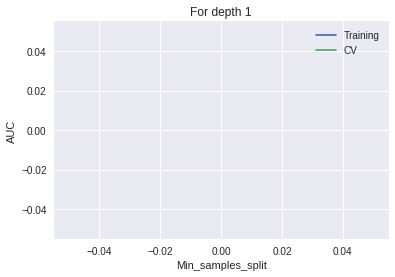

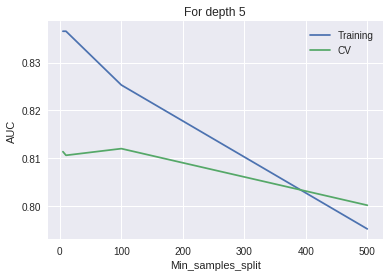

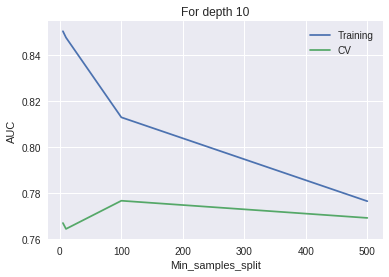

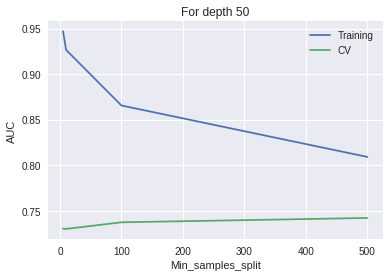

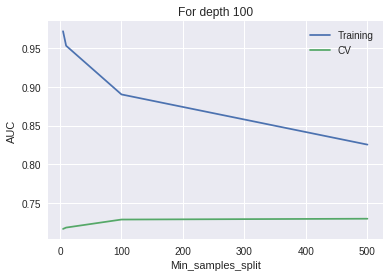

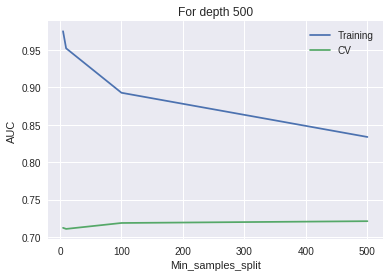

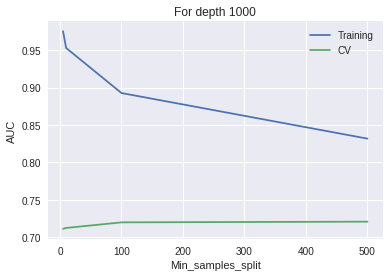

In [58]:
for d in Depth:
  AUC_training=[]
  AUC_cv=[]
  for m in Min_samples_split:
    clf=DecisionTreeClassifier(criterion='gini',min_samples_split=m,max_depth=d)
    clf.fit(train_bows,y_train)
    
    #Training Data
    y_predict_train=clf.predict(train_bows)
    fpr,tpr,thresholds=roc_curve(y_predict_train,y_train)
    AUC_training.append(metrics.auc(fpr,tpr))
    
    #CV Curve
    y_predict_cv=clf.predict(cv_bows)
    fpr, tpr, thresholds = roc_curve(y_predict_cv, y_cv)
    AUC_cv.append(metrics.auc(fpr, tpr))
    
  #Plotting Graph
    
  plt.plot(Min_samples_split,AUC_training,label='Training')
  plt.plot(Min_samples_split,AUC_cv,label="CV")
  plt.ylabel('AUC')
  plt.xlabel('Min_samples_split')
  plt.title('For depth %d'%d)
  plt.legend()
  plt.show()
    

**Observation:** Optimal value of Depth =5 and Min_samples_split =100 having AUC=0.82

In [0]:
#For Optimal on test data
count_vectorizer=CountVectorizer()
Train_bows=count_vectorizer.fit_transform(Train_data)
test_bows=count_vectorizer.transform(test_data)


 AUC =  0.7695555116107499


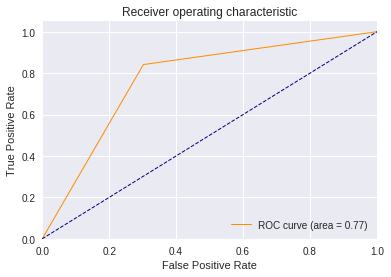




              precision    recall  f1-score   support

           0       0.70      0.11      0.19      5216
           1       0.84      0.99      0.91     24784

   micro avg       0.84      0.84      0.84     30000
   macro avg       0.77      0.55      0.55     30000
weighted avg       0.82      0.84      0.79     30000



In [60]:
clf=DecisionTreeClassifier(criterion='gini',min_samples_split=100,max_depth=5)
clf.fit(Train_bows,y_Train)
y_pred=clf.predict(test_bows)
 #Drawing ROC curve
fpr, tpr, thresholds = roc_curve(y_pred, y_test)
roc_auc = auc(fpr, tpr)
print(' AUC = ',metrics.auc(fpr, tpr))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
print("\n\n")
print(metrics.classification_report(y_test,y_pred))

# 5.1.1 Top 20 Features

In [0]:
a=clf.feature_importances_

In [82]:
a.shape
type(a)

numpy.ndarray

In [0]:
feature_names=count_vectorizer.get_feature_names()

In [70]:
len(feature_names)

50699

In [0]:
top=zip(a,feature_names)
top=list(top)
top.sort(reverse=True,key=lambda x:x[0])


In [87]:
for i in range(0,20):
  print("%.2f"%top[i][0],'\t',top[i][1])

0.26 	 not
0.17 	 great
0.15 	 worst
0.12 	 money
0.09 	 best
0.07 	 disappointed
0.05 	 horrible
0.04 	 waste
0.03 	 awful
0.01 	 thought
0.00 	 threw
0.00 	 cat
0.00 	 eating
0.00 	 time
0.00 	 loves
0.00 	 nice
0.00 	 ginger
0.00 	 aa
0.00 	 aaa
0.00 	 aaaaa


# Graphviz visualization of Decision Tree on BOW, SET 1

In [0]:
from sklearn import tree
import pydotplus
import collections

In [0]:
dot_data=tree.export_graphviz(clf,feature_names=feature_names,out_file=None,filled=True,max_depth=3,rounded=True)

In [110]:
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

graph.write_png('tree.png')

True

In [0]:
from google.colab import files
files.download('tree.png')

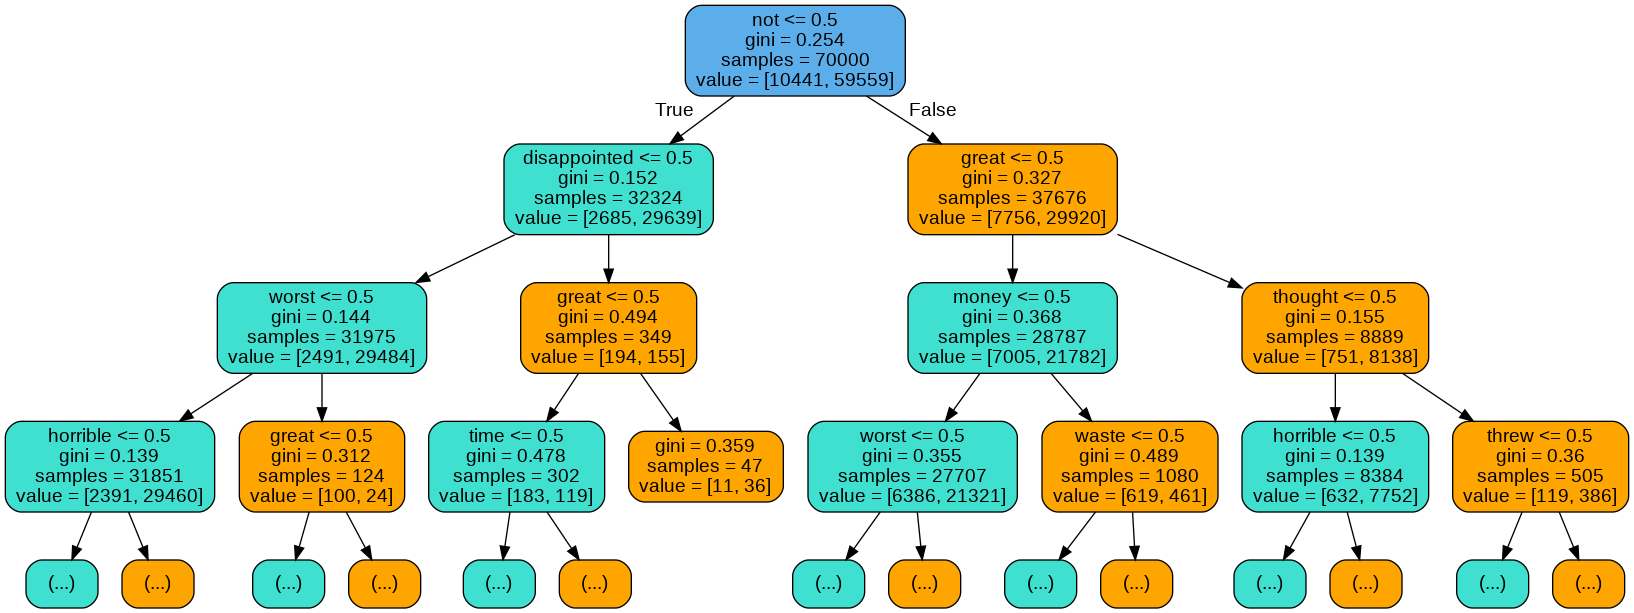

In [127]:
from IPython.display import Image
Image('tree.png',width=1000,height=500)

# [5.2] Applying Decision Trees on TFIDF,

In [0]:
Depth=[1, 5, 10, 50, 100, 500, 1000]
Min_samples_split=[5, 10, 100, 500]

**Simple Cross Validation**

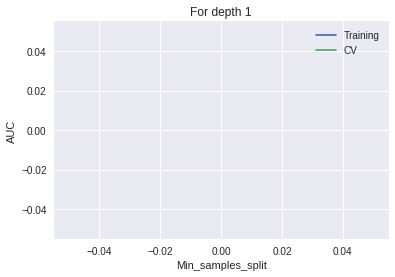

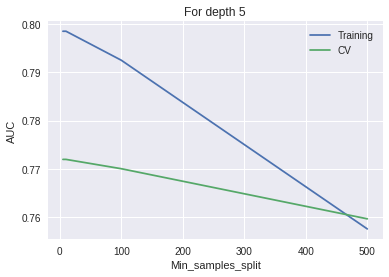

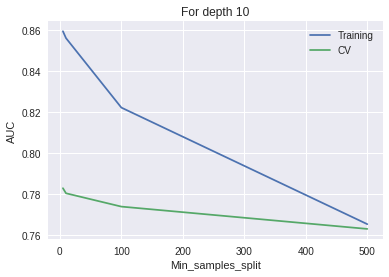

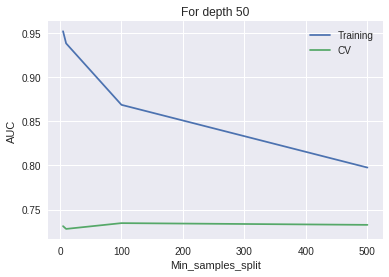

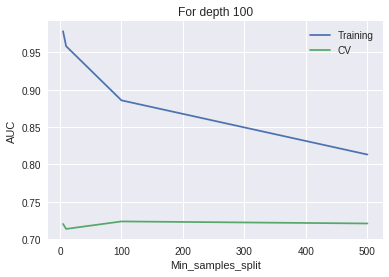

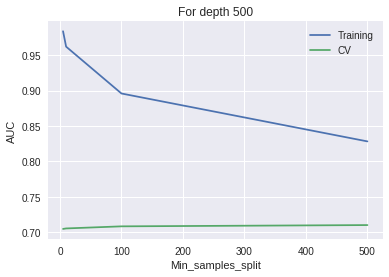

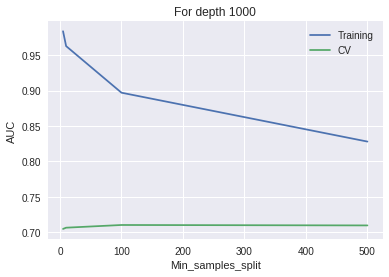

In [129]:
for d in Depth:
  AUC_training=[]
  AUC_cv=[]
  for m in Min_samples_split:
    clf=DecisionTreeClassifier(criterion='gini',min_samples_split=m,max_depth=d)
    clf.fit(train_tfidf,y_train)
    
    #Training Data
    y_predict_train=clf.predict(train_tfidf)
    fpr,tpr,thresholds=roc_curve(y_predict_train,y_train)
    AUC_training.append(metrics.auc(fpr,tpr))
    
    #CV Curve
    y_predict_cv=clf.predict(cv_tfidf)
    fpr, tpr, thresholds = roc_curve(y_predict_cv, y_cv)
    AUC_cv.append(metrics.auc(fpr, tpr))
    
  #Plotting Graph
    
  plt.plot(Min_samples_split,AUC_training,label='Training')
  plt.plot(Min_samples_split,AUC_cv,label="CV")
  plt.ylabel('AUC')
  plt.xlabel('Min_samples_split')
  plt.title('For depth %d'%d)
  plt.legend()
  plt.show()
  

**Optimal Value of Depth=5 and Min_Samples_Split=100**

In [0]:
#For Optimal on test data
tfidf_vectorizer=TfidfVectorizer()
Train_tfidf=tfidf_vectorizer.fit_transform(Train_data)
test_tfidf=tfidf_vectorizer.transform(test_data)

 AUC =  0.7974441131532494


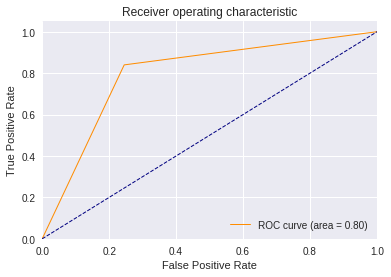




              precision    recall  f1-score   support

           0       0.76      0.10      0.18      5216
           1       0.84      0.99      0.91     24784

   micro avg       0.84      0.84      0.84     30000
   macro avg       0.80      0.55      0.54     30000
weighted avg       0.83      0.84      0.78     30000



In [131]:
clf=DecisionTreeClassifier(criterion='gini',min_samples_split=100,max_depth=5)
clf.fit(Train_tfidf,y_Train)
y_pred=clf.predict(test_tfidf)
 #Drawing ROC curve
fpr, tpr, thresholds = roc_curve(y_pred, y_test)
roc_auc = auc(fpr, tpr)
print(' AUC = ',metrics.auc(fpr, tpr))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
print("\n\n")
print(metrics.classification_report(y_test,y_pred))


# 5.2.2 Top 20 important features from TFIDF

In [132]:
a=clf.feature_importances_
feature_names=tfidf_vectorizer.get_feature_names()
top=zip(a,feature_names)
top=list(top)
top.sort(reverse=True,key=lambda x:x[0])
for i in range(0,20):
  print("%.2f"%top[i][0],'\t',top[i][1])

0.26 	 not
0.17 	 great
0.15 	 worst
0.12 	 money
0.08 	 best
0.07 	 disappointed
0.05 	 horrible
0.04 	 waste
0.03 	 awful
0.01 	 thought
0.00 	 threw
0.00 	 love
0.00 	 eating
0.00 	 since
0.00 	 bit
0.00 	 price
0.00 	 cat
0.00 	 aa
0.00 	 aaa
0.00 	 aaaaa


# Graphviz visualization of Decision Tree on TFIDF

In [0]:
from sklearn import tree
import pydotplus
import collections

In [0]:
dot_data=tree.export_graphviz(clf,feature_names=feature_names,out_file=None,filled=True,max_depth=3,rounded=True)

In [137]:
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

graph.write_png('tree2.png')

True

In [0]:
from google.colab import files
files.download('tree2.png')

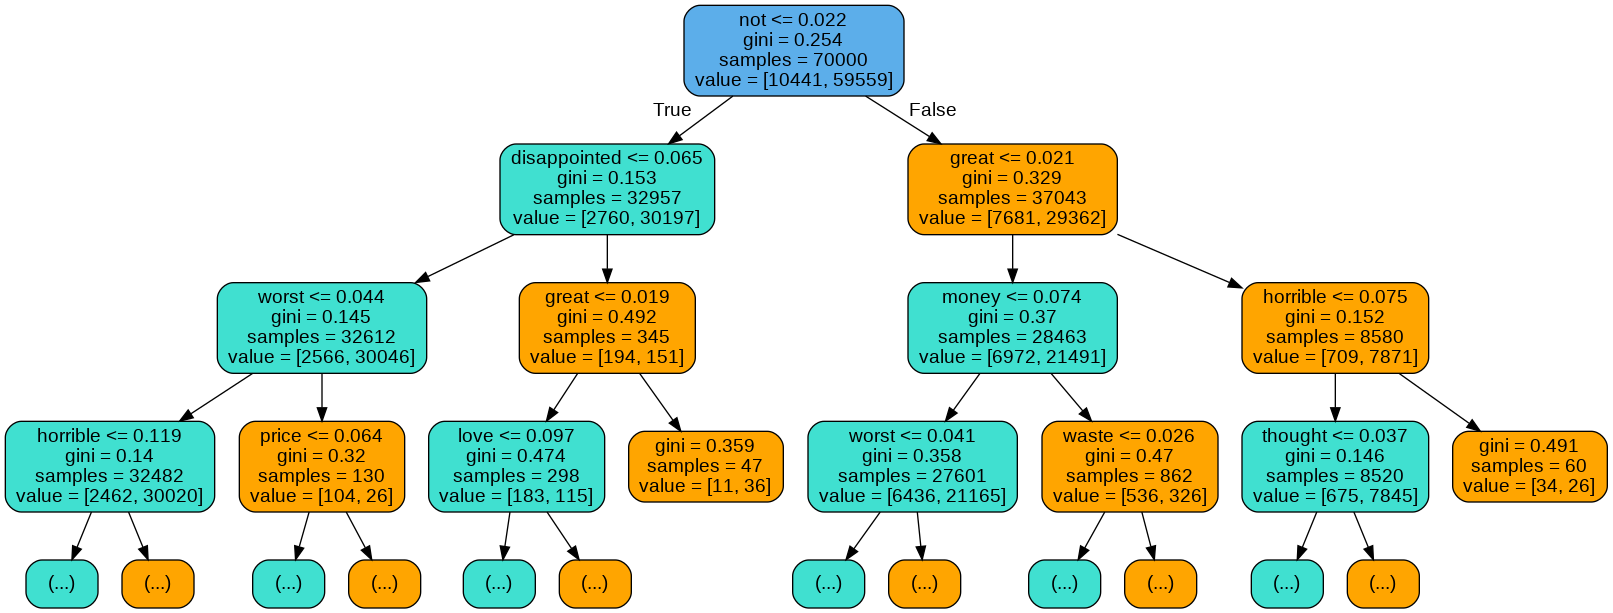

In [139]:
from IPython.display import Image
Image('tree.png',width=1000,height=500)

# 5.3 Applying Decision Trees on AVG W2V

In [0]:
Depth=[1, 5, 10, 50, 100, 500, 1000]
Min_samples_split=[5, 10, 100, 500]

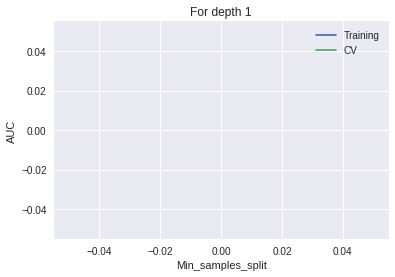

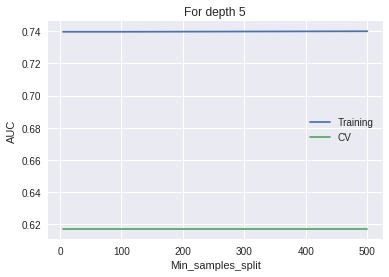

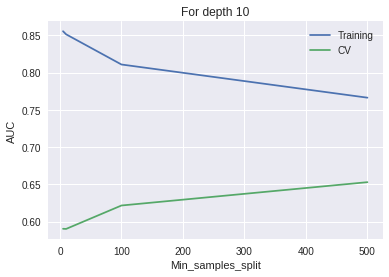

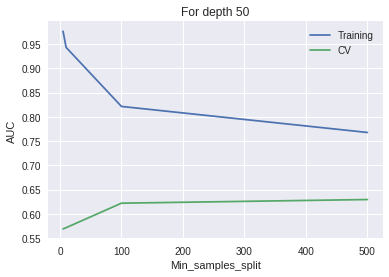

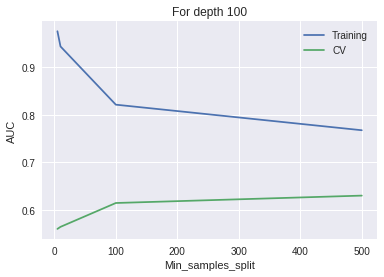

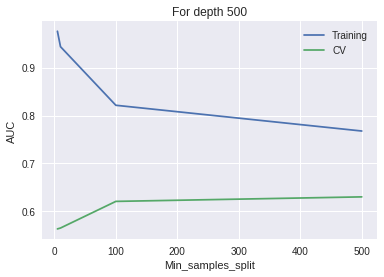

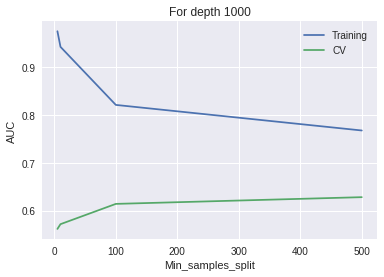

In [141]:
for d in Depth:
  AUC_training=[]
  AUC_cv=[]
  for m in Min_samples_split:
    clf=DecisionTreeClassifier(criterion='gini',min_samples_split=m,max_depth=d)
    clf.fit(sent_vectors, y_train)
    
    #Training Data
    y_predict_train=clf.predict(sent_vectors)
    fpr,tpr,thresholds=roc_curve(y_predict_train,y_train)
    AUC_training.append(metrics.auc(fpr,tpr))
    
    #CV Curve
    y_predict_cv=clf.predict(sent_vectors_cv)
    fpr, tpr, thresholds = roc_curve(y_predict_cv, y_cv)
    AUC_cv.append(metrics.auc(fpr, tpr))
    
  #Plotting Graph
    
  plt.plot(Min_samples_split,AUC_training,label='Training')
  plt.plot(Min_samples_split,AUC_cv,label="CV")
  plt.ylabel('AUC')
  plt.xlabel('Min_samples_split')
  plt.title('For depth %d'%d)
  plt.legend()
  plt.show()
  

**Optimal value of Max_Depth=5  and Min_samples_split=100**

**Optimal Classifier**

 AUC =  0.7379975318554203


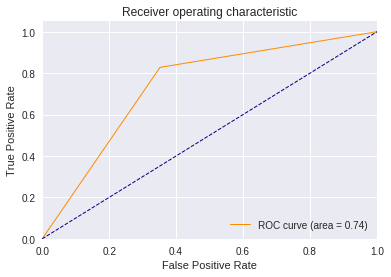




              precision    recall  f1-score   support

           0       0.65      0.01      0.03      5216
           1       0.83      1.00      0.91     24784

   micro avg       0.83      0.83      0.83     30000
   macro avg       0.74      0.51      0.47     30000
weighted avg       0.80      0.83      0.75     30000



In [142]:
clf=DecisionTreeClassifier(criterion='gini',min_samples_split=100,max_depth=5)
clf.fit(sent_vectors,y_train)
y_pred=clf.predict(sent_vectors_test)
 #Drawing ROC curve
fpr, tpr, thresholds = roc_curve(y_pred, y_test)
roc_auc = auc(fpr, tpr)
print(' AUC = ',metrics.auc(fpr, tpr))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
print("\n\n")
print(metrics.classification_report(y_test,y_pred))

# 5.2.4Applying Decision Trees on TFIDF W2V

In [0]:
Depth=[1, 5, 10, 50, 100, 500, 1000]
Min_samples_split=[5, 10, 100, 500]

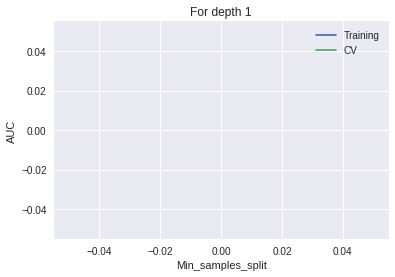

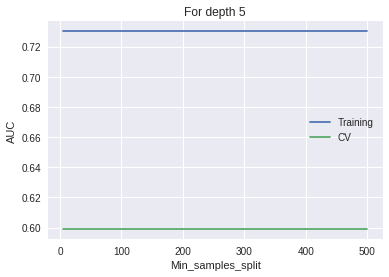

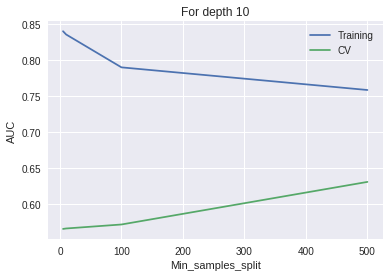

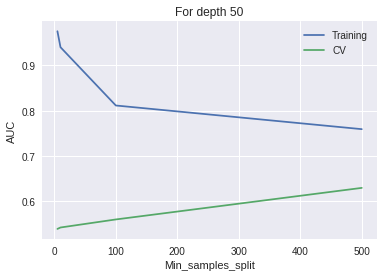

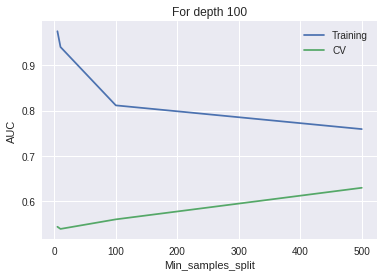

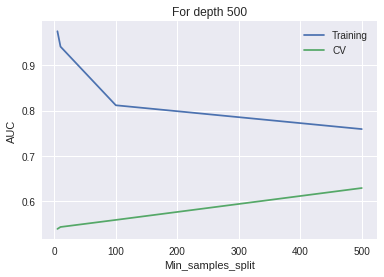

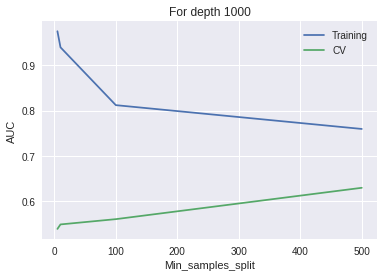

In [144]:
for d in Depth:
  AUC_training=[]
  AUC_cv=[]
  for m in Min_samples_split:
    clf=DecisionTreeClassifier(criterion='gini',min_samples_split=m,max_depth=d)
    clf.fit(tfidf_sent_vectors_train, y_train)
    
    #Training Data
    y_predict_train=clf.predict(tfidf_sent_vectors_train)
    fpr,tpr,thresholds=roc_curve(y_predict_train,y_train)
    AUC_training.append(metrics.auc(fpr,tpr))
    
    #CV Curve
    y_predict_cv=clf.predict(tfidf_sent_vectors_cv)
    fpr, tpr, thresholds = roc_curve(y_predict_cv, y_cv)
    AUC_cv.append(metrics.auc(fpr, tpr))
    
  #Plotting Graph
    
  plt.plot(Min_samples_split,AUC_training,label='Training')
  plt.plot(Min_samples_split,AUC_cv,label="CV")
  plt.ylabel('AUC')
  plt.xlabel('Min_samples_split')
  plt.title('For depth %d'%d)
  plt.legend()
  plt.show()
  

**Optimal value of Max_Depth=10 and Min_Samples_Split=50**

**Optimal Classifier**

 AUC =  0.6561904761904762


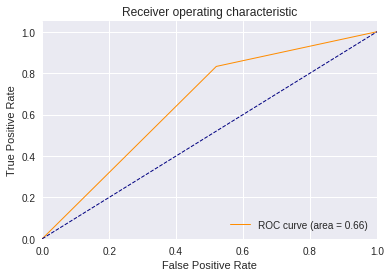




              precision    recall  f1-score   support

           0       0.48      0.06      0.10      5216
           1       0.83      0.99      0.90     24784

   micro avg       0.83      0.83      0.83     30000
   macro avg       0.66      0.52      0.50     30000
weighted avg       0.77      0.83      0.76     30000



In [145]:
clf=DecisionTreeClassifier(criterion='gini',min_samples_split=500,max_depth=10)
clf.fit(tfidf_sent_vectors_train,y_train)
y_pred=clf.predict(tfidf_sent_vectors_test)
 #Drawing ROC curve
fpr, tpr, thresholds = roc_curve(y_pred, y_test)
roc_auc = auc(fpr, tpr)
print(' AUC = ',metrics.auc(fpr, tpr))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
print("\n\n")
print(metrics.classification_report(y_test,y_pred))